# SRCNN V1

## Understanding the Dataset

### 1) Installing Dataset

In [2]:
!pip install tacoreader rasterio matplotlib

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   -- ------------------------------------- 1.8/25.4 MB 9.1 MB/s eta 0:00:03
   ----- ---------------------------------- 3.4/25.4 MB 9.1 MB/s eta 0:00:03
   --------- ------------------------------ 5.8/25.4 MB 9.3 MB/s eta 0:00:03
   ----------- ---------------------------- 7.6/25.4 MB 9.2 MB/s eta 0:00:02
   -------------- ------------------------- 9.4/25.4 MB 9.2 MB/s eta 0:00:02
   ----------------- ---------------------- 11.3/25.4 MB 9.2 MB/s eta 0:00:02
   -------------------- ------------------- 13.1/25.4 MB 9.2 MB/s eta 0:00:02
   ----------------------- ---------------- 15.2/25.4 MB 9.2 MB/s eta 0:00:02
   -------------------------- ------------- 17.0/25.4 MB 9.2 MB/s eta 0:00:01
   ----------------------------- ---------- 18.9/25.4 MB 9.2 MB/s eta 0:00:01
   -------------------------------- ------- 21.0/25.4 MB 9.2 MB/s eta 0:00:01
   ----------------------------------- ---- 22.8/25.4 MB 9.2 MB/s eta 0:00:01

In [4]:
!pip install requests aiohttp

### 2) Load a sample using tacoreader

In [7]:
import tacoreader
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
dataset = tacoreader.load("tacofoundation:sen2naipv2-crosssensor")

# Choose a sample
sample_idx = 3000
lr_ref = dataset.read(sample_idx).read(0)  # Low-res (Sentinel-2-like)
hr_ref = dataset.read(sample_idx).read(1)  # High-res (NAIP)

# Open with rasterio
with rio.open(lr_ref) as src_lr, rio.open(hr_ref) as src_hr:
    lr_data = src_lr.read(window=rio.windows.Window(0, 0, 64, 64))   # 64x64 LR
    hr_data = src_hr.read(window=rio.windows.Window(0, 0, 256, 256)) # 256x256 HR


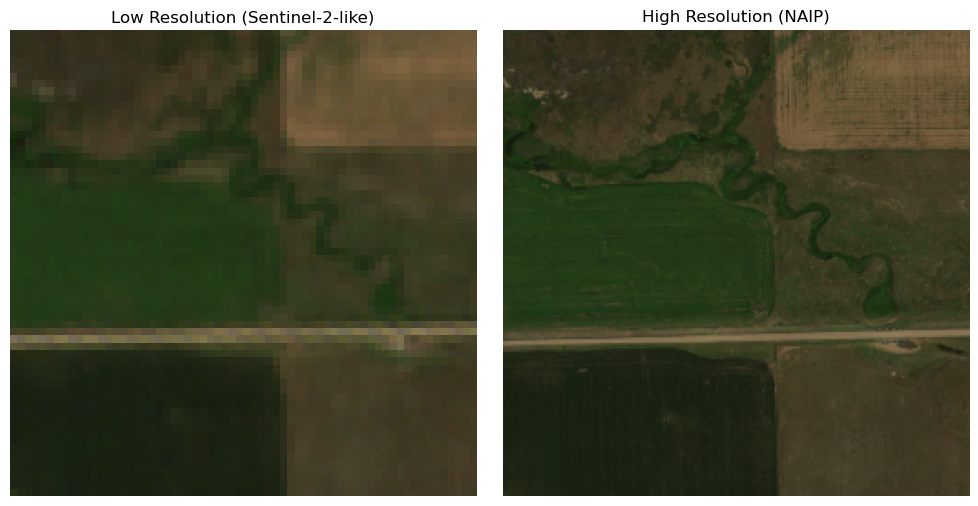

In [8]:
# Display the LR and HR images side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Normalize and transpose for plotting (assumes RGB in first 3 bands)
ax[0].imshow(np.clip(lr_data[:3].transpose(1, 2, 0) / 3000.0, 0, 1))
ax[0].set_title("Low Resolution (Sentinel-2-like)")
ax[0].axis("off")

ax[1].imshow(np.clip(hr_data[:3].transpose(1, 2, 0) / 3000.0, 0, 1))
ax[1].set_title("High Resolution (NAIP)")
ax[1].axis("off")

plt.tight_layout()
plt.show()


### 3) Convert to tensors

In [9]:
import torch

# Convert to PyTorch tensors
def to_tensor_gray(data, scale=3000.0):
    rgb = data[:3] / scale  # Normalize
    gray = 0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2]
    tensor = torch.tensor(gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    return tensor

lr_tensor = to_tensor_gray(lr_data)
hr_tensor = to_tensor_gray(hr_data)

print(f"LR tensor shape: {lr_tensor.shape}, dtype: {lr_tensor.dtype}")
print(f"HR tensor shape: {hr_tensor.shape}, dtype: {hr_tensor.dtype}")

LR tensor shape: torch.Size([1, 1, 64, 64]), dtype: torch.float32
HR tensor shape: torch.Size([1, 1, 256, 256]), dtype: torch.float32


### 4) dataset class for training

In [10]:
from torch.utils.data import Dataset
import torch
import rasterio as rio
import tacoreader
import numpy as np

class Sen2NaipDataset(Dataset):
    def __init__(self, split="tacofoundation:sen2naipv2-crosssensor", indices=None, patch_size=64, scale=4):
        self.dataset = tacoreader.load(split)
        self.indices = indices if indices else range(len(self.dataset))
        self.patch_size = patch_size
        self.scale = scale
        self.hr_patch_size = patch_size * scale

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        lr_ref = self.dataset.read(sample_idx).read(0)
        hr_ref = self.dataset.read(sample_idx).read(1)

        with rio.open(lr_ref) as src_lr, rio.open(hr_ref) as src_hr:
            # Ensure consistent starting location
            lr_data = src_lr.read(window=rio.windows.Window(0, 0, self.patch_size, self.patch_size))
            hr_data = src_hr.read(window=rio.windows.Window(0, 0, self.hr_patch_size, self.hr_patch_size))

        # Preprocess to grayscale and normalize
        lr_tensor = self.to_tensor_gray(lr_data)
        hr_tensor = self.to_tensor_gray(hr_data)

        return lr_tensor, hr_tensor

    def to_tensor_gray(self, data, norm=3000.0):
        rgb = data[:3] / norm
        gray = 0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2]
        tensor = torch.tensor(gray, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        return tensor


In [11]:
from torch.utils.data import DataLoader

# Create dataset (using 10 samples for test purposes)
dataset = Sen2NaipDataset(indices=range(10))

# Wrap in DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate
for i, (lr, hr) in enumerate(loader):
    print(f"Sample {i} | LR shape: {lr.shape}, HR shape: {hr.shape}")
    if i == 2: break


Sample 0 | LR shape: torch.Size([1, 1, 64, 64]), HR shape: torch.Size([1, 1, 256, 256])
Sample 1 | LR shape: torch.Size([1, 1, 64, 64]), HR shape: torch.Size([1, 1, 256, 256])
Sample 2 | LR shape: torch.Size([1, 1, 64, 64]), HR shape: torch.Size([1, 1, 256, 256])


### 5) SRCNN class and bicubic

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.layer3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [14]:
import torch.nn.functional as F

# Example upsample (for inference or training)
upsampled = F.interpolate(lr_tensor, scale_factor=4, mode='bicubic', align_corners=False)
output = model(upsampled)


NameError: name 'model' is not defined

### Training

In [17]:
import math

def compute_psnr(output, target, max_pixel=1.0):
    mse = torch.mean((output - target) ** 2)  # Mean Squared Error
    if mse == 0:
        return 100  # Maximum PSNR
    return 20 * math.log10(max_pixel / math.sqrt(mse))


In [18]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the SRCNN model
model = SRCNN().to(device)

# Set up DataLoader (for training and validation)
train_dataset = Sen2NaipDataset(split="tacofoundation:sen2naipv2-unet", indices=range(100))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0

    for i, (lr, hr) in enumerate(train_loader):
        lr, hr = lr.to(device), hr.to(device)

        # Upsample LR image to HR size
        upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(upsampled)

        # Compute the loss
        loss = criterion(output, hr)
        loss.backward()  # Backpropagation

        # Update weights
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    # Compute PSNR after each epoch
    psnr = compute_psnr(output, hr)
    print(f"Epoch [{epoch+1}/{num_epochs}], PSNR: {psnr:.2f} dB")

    # Optionally, save the model after each epoch
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"srcnn_epoch_{epoch+1}.pth")


Epoch [1/10], Step [100/100], Loss: 0.0089
Epoch [1/10], PSNR: 23.59 dB
Epoch [2/10], Step [100/100], Loss: 0.0029
Epoch [2/10], PSNR: 24.19 dB
Epoch [3/10], Step [100/100], Loss: 0.0026
Epoch [3/10], PSNR: 33.41 dB
Epoch [4/10], Step [100/100], Loss: 0.0023
Epoch [4/10], PSNR: 34.09 dB
Epoch [5/10], Step [100/100], Loss: 0.0021
Epoch [5/10], PSNR: 24.73 dB
Epoch [6/10], Step [100/100], Loss: 0.0020
Epoch [6/10], PSNR: 31.18 dB
Epoch [7/10], Step [100/100], Loss: 0.0020
Epoch [7/10], PSNR: 24.32 dB
Epoch [8/10], Step [100/100], Loss: 0.0020
Epoch [8/10], PSNR: 31.76 dB
Epoch [9/10], Step [100/100], Loss: 0.0019
Epoch [9/10], PSNR: 28.71 dB
Epoch [10/10], Step [100/100], Loss: 0.0019
Epoch [10/10], PSNR: 26.32 dB


In [2]:
import matplotlib.pyplot as plt
import random

# Put model in evaluation mode
model.eval()

# Pick a random sample from the dataset
random_idx = random.randint(0, len(train_dataset) - 1)
lr, hr = train_dataset[random_idx]

# Move to device
lr = lr.to(device).unsqueeze(0)  # Add batch dimension
hr = hr.to(device).unsqueeze(0)

# Upsample the LR image to HR size using bicubic interpolation
upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

# Pass through the trained SRCNN
with torch.no_grad():
    sr = model(upsampled)

# Move data to CPU and squeeze for visualization
lr_img = lr.squeeze().cpu().numpy()
hr_img = hr.squeeze().cpu().numpy()
sr_img = sr.squeeze().cpu().numpy()

# Plot all three images side-by-side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lr_img, cmap='gray')
plt.title("Low-Resolution (Input)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hr_img, cmap='gray')
plt.title("High-Resolution (Ground Truth)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sr_img, cmap='gray')
plt.title("SRCNN Output")
plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined